In [1]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import my_stats

In [2]:
df = my_stats.make_data()
print(df.shape)
df.head()

(30, 8)


trials_a  trials_b    prob_a    prob_b  successes_a  successes_b      cr_a  \
0    4645.0    4649.0  0.004429  0.004510         15.0         28.0  0.003229   
1    4794.0    4814.0  0.005251  0.003992         28.0         34.0  0.005841   
2    4630.0    4622.0  0.003775  0.003821         13.0         22.0  0.002808   
3    4810.0    4809.0  0.004845  0.005806         19.0         29.0  0.003950   
4    5018.0    5022.0  0.004427  0.004914         17.0         30.0  0.003388   

       cr_b  
0  0.006023  
1  0.007063  
2  0.004760  
3  0.006030  
4  0.005974

In [3]:
with pm.Model() as model_simple:
    beta_a = pm.Beta('beta_a', alpha=my_stats.PRIOR_ALPHA, beta=my_stats.PRIOR_BETA)
    beta_b = pm.Beta('beta_b', alpha=my_stats.PRIOR_ALPHA, beta=my_stats.PRIOR_BETA)
    
    obs_a = pm.Binomial('obs_a', n=df['trials_a'].values, p=beta_a, observed=df['successes_a'].values)
    obs_b = pm.Binomial('obs_b', n=df['trials_b'].values, p=beta_b, observed=df['successes_b'].values)

In [4]:
with model_simple:
    step = pm.Metropolis()
    trace_simple = pm.sample(200000, tune=20000, step=step, init='advi')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_b]
>Metropolis: [beta_a]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 880000/880000 [03:19<00:00, 4405.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [7]:
beta_a_exact = stats.beta(
    a=my_stats.PRIOR_ALPHA + df['successes_a'].sum(),
    b=my_stats.PRIOR_BETA + df['trials_a'].sum() - df['successes_a'].sum()
)
beta_b_exact = stats.beta(
    a=my_stats.PRIOR_ALPHA + df['successes_b'].sum(),
    b=my_stats.PRIOR_BETA + df['trials_b'].sum() - df['successes_b'].sum()
)

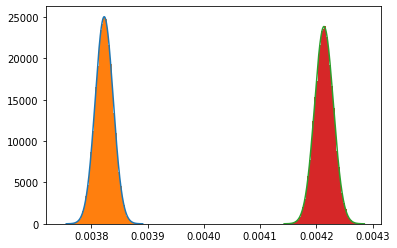

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1)

x_0 = np.linspace(beta_a_exact.ppf(0.00001), beta_a_exact.ppf(0.99999), 1000)
ax.plot(x_0, beta_a_exact.pdf(x_0))
ax.hist(trace_simple.get_values('beta_a', burn=50000), density=True, bins=50)

x_1 = np.linspace(beta_b_exact.ppf(0.00001), beta_b_exact.ppf(0.99999), 1000)
ax.plot(x_1, beta_b_exact.pdf(x_1))
ax.hist(trace_simple.get_values('beta_b', burn=50000), density=True, bins=50)

plt.show()

In [7]:
with pm.Model() as model_three_params:
    alpha_1 = alpha_2 = my_stats.PRIOR_ALPHA
    alpha_5 = my_stats.PRIOR_BETA
    u_1 = pm.Gamma('u_1', alpha=alpha_1, beta=1)
    u_2 = pm.Gamma('u_2', alpha=alpha_2, beta=1)
    u_5 = pm.Gamma('u_5', alpha=alpha_5, beta=1)
    
#     margin_a = pm.Beta('margin_a', alpha=alpha_1, beta=alpha_5)
#     margin_b = pm.Beta('margin_b', alpha=alpha_2, beta=alpha_5)
    
    beta_a = pm.Deterministic('beta_a', (u_1)/(u_1+u_5))
    beta_b = pm.Deterministic('beta_b', (u_2)/(u_2+u_5))
    
#     obs_a = pm.Binomial('obs_a', n=df['trials_a'].values, p=beta_a, observed=df['successes_a'].values)
#     obs_b = pm.Binomial('obs_b', n=df['trials_b'].values, p=beta_b, observed=df['successes_b'].values)
    
    beta = tt.stack([beta_a, beta_b])
    obs = pm.Binomial(
        'obs',
        n=df[['trials_a', 'trials_b']].values,
        p=beta,
        observed=df[['successes_a', 'successes_b']].values
    )

In [8]:
with model_three_params:
    step = pm.Metropolis()
    trace_three_params = pm.sample(200000, tune=20000, step=step, init='advi')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [u_5]
>Metropolis: [u_2]
>Metropolis: [u_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 880000/880000 [04:20<00:00, 3381.66draws/s]
The number of effective samples is smaller than 10% for some parameters.


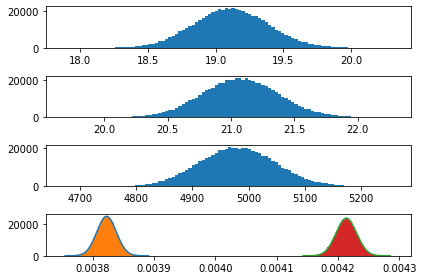

In [9]:
fig, (ax_0, ax_1, ax_2, ax_3) = plt.subplots(nrows=4, ncols=1)

ax_0.hist(trace_three_params.get_values('u_1', burn=50000), density=False, bins=100)
ax_1.hist(trace_three_params.get_values('u_2', burn=50000), density=False, bins=100)
ax_2.hist(trace_three_params.get_values('u_5', burn=50000), density=False, bins=100)

x_0 = np.linspace(beta_a_exact.ppf(0.00001), beta_a_exact.ppf(0.99999), 1000)
ax_3.plot(x_0, beta_a_exact.pdf(x_0))
ax_3.hist(trace_three_params.get_values('beta_a', burn=50000), density=True, bins=50)

x_1 = np.linspace(beta_b_exact.ppf(0.00001), beta_b_exact.ppf(0.99999), 1000)
ax_3.plot(x_1, beta_b_exact.pdf(x_1))
ax_3.hist(trace_three_params.get_values('beta_b', burn=50000), density=True, bins=50)

plt.tight_layout()
plt.show()

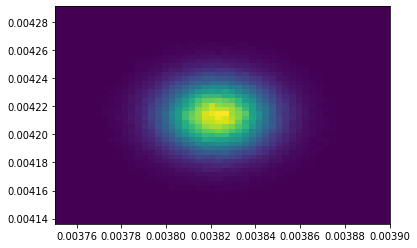

In [10]:
plt.hist2d(trace_three_params.get_values('beta_a', burn=10000), trace_three_params.get_values('beta_b', burn=10000), bins=50)
plt.show()

In [4]:
with pm.Model() as model_five_params:
    alpha_3 = alpha_4 = 1
    alpha_1 = alpha_2 = my_stats.PRIOR_ALPHA - alpha_3
    alpha_5 = my_stats.PRIOR_BETA - alpha_3
    
    u_1 = pm.Gamma('u_1', alpha=alpha_1, beta=1)
    u_2 = pm.Gamma('u_2', alpha=alpha_2, beta=1)
    u_3 = pm.Gamma('u_3', alpha=alpha_3, beta=1)
    u_4 = pm.Gamma('u_4', alpha=alpha_4, beta=1)
    u_5 = pm.Gamma('u_5', alpha=alpha_5, beta=1)
    
#     margin_a = pm.Beta('margin_a', alpha=alpha_1+alpha_3, beta=alpha_4+alpha_5)
#     margin_b = pm.Beta('margin_b', alpha=alpha_2+alpha_4, beta=alpha_3+alpha_5)
    
    beta_a = pm.Deterministic('beta_a', (u_1+u_3)/(u_1+u_3+u_4+u_5))
    beta_b = pm.Deterministic('beta_b', (u_2+u_4)/(u_2+u_3+u_4+u_5))
    
#     obs_a = pm.Binomial('obs_a', n=df['trials_a'].values, p=beta_a, observed=df['successes_a'].values)
#     obs_b = pm.Binomial('obs_b', n=df['trials_b'].values, p=beta_b, observed=df['successes_b'].values)

    beta = tt.stack([beta_a, beta_b])
    obs = pm.Binomial(
        'obs',
        n=df[['trials_a', 'trials_b']].values,
        p=beta,
        observed=df[['successes_a', 'successes_b']].values
    )

In [5]:
with model_five_params:
    step = pm.Metropolis()
    trace_five_params = pm.sample(200000, tune=20000, step=step, init='advi')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [u_5]
>Metropolis: [u_4]
>Metropolis: [u_3]
>Metropolis: [u_2]
>Metropolis: [u_1]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 880000/880000 [04:28<00:00, 3274.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


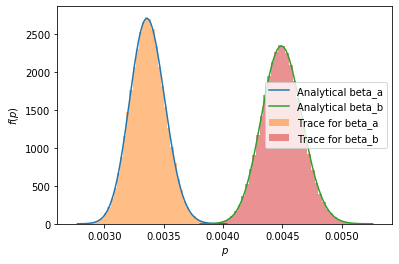

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)

x_0 = np.linspace(beta_a_exact.ppf(0.00001), beta_a_exact.ppf(0.99999), 1000)
ax.plot(x_0, beta_a_exact.pdf(x_0), label='Analytical beta_a')
ax.hist(trace_five_params.get_values('beta_a', burn=50000), density=True, bins=50, alpha=0.5, label='Trace for beta_a')

x_1 = np.linspace(beta_b_exact.ppf(0.00001), beta_b_exact.ppf(0.99999), 1000)
ax.plot(x_1, beta_b_exact.pdf(x_1), label='Analytical beta_b')
ax.hist(trace_five_params.get_values('beta_b', burn=50000), density=True, bins=50, alpha=0.5, label='Trace for beta_b')

ax.legend()
ax.set_xlabel('$p$')
ax.set_ylabel('$f(p)$')

plt.show()

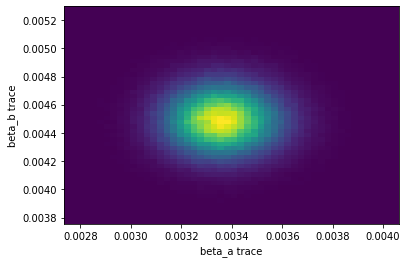

In [16]:
fig, ax = plt.subplots()
ax.hist2d(
    trace_five_params.get_values('beta_a', burn=50000),
    trace_five_params.get_values('beta_b', burn=50000),
    bins=50
)
ax.set_xlabel('beta_a trace')
ax.set_ylabel('beta_b trace')
plt.show()

In [15]:
print(trace_five_params.get_values('beta_a', chains=[0]).mean())
print(trace_five_params.get_values('beta_b', chains=[0]).mean())
print(np.corrcoef(trace_five_params.get_values('beta_a', chains=[0])[50000:], trace_five_params.get_values('beta_b', chains=[0])[50000:]))

0.0038229084119774724
0.00421362952735994
[[ 1.         -0.00154337]
 [-0.00154337  1.        ]]


In [9]:
print(my_stats.PROB_A_ALPHA / (my_stats.PROB_A_ALPHA + my_stats.PROB_A_BETA))
print(my_stats.PROB_B_ALPHA / (my_stats.PROB_B_ALPHA + my_stats.PROB_B_BETA))

0.0036
0.0044


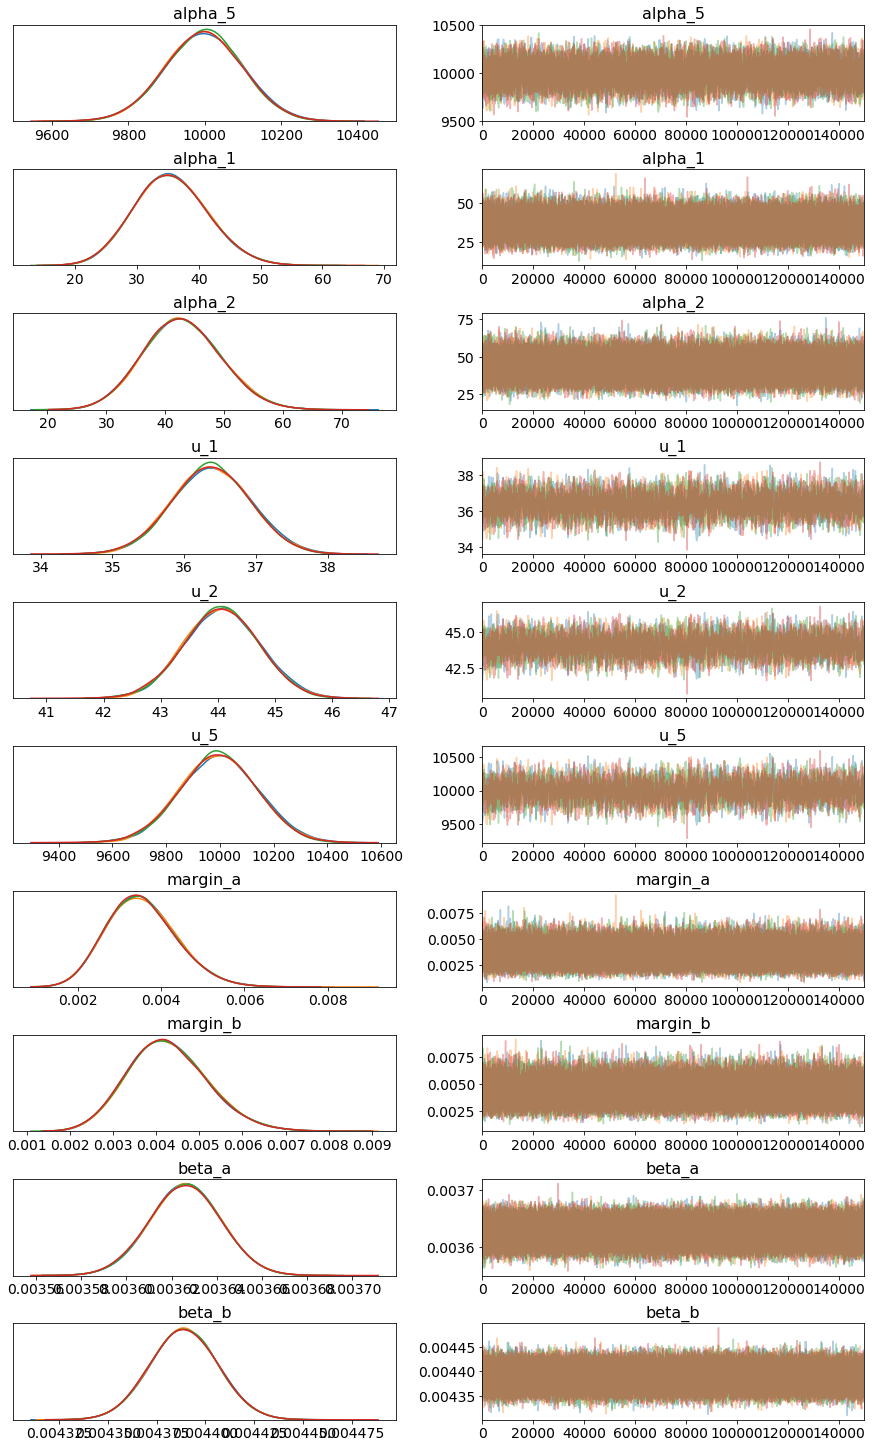

In [10]:
pm.plots.traceplot(trace[50000:])
plt.show()

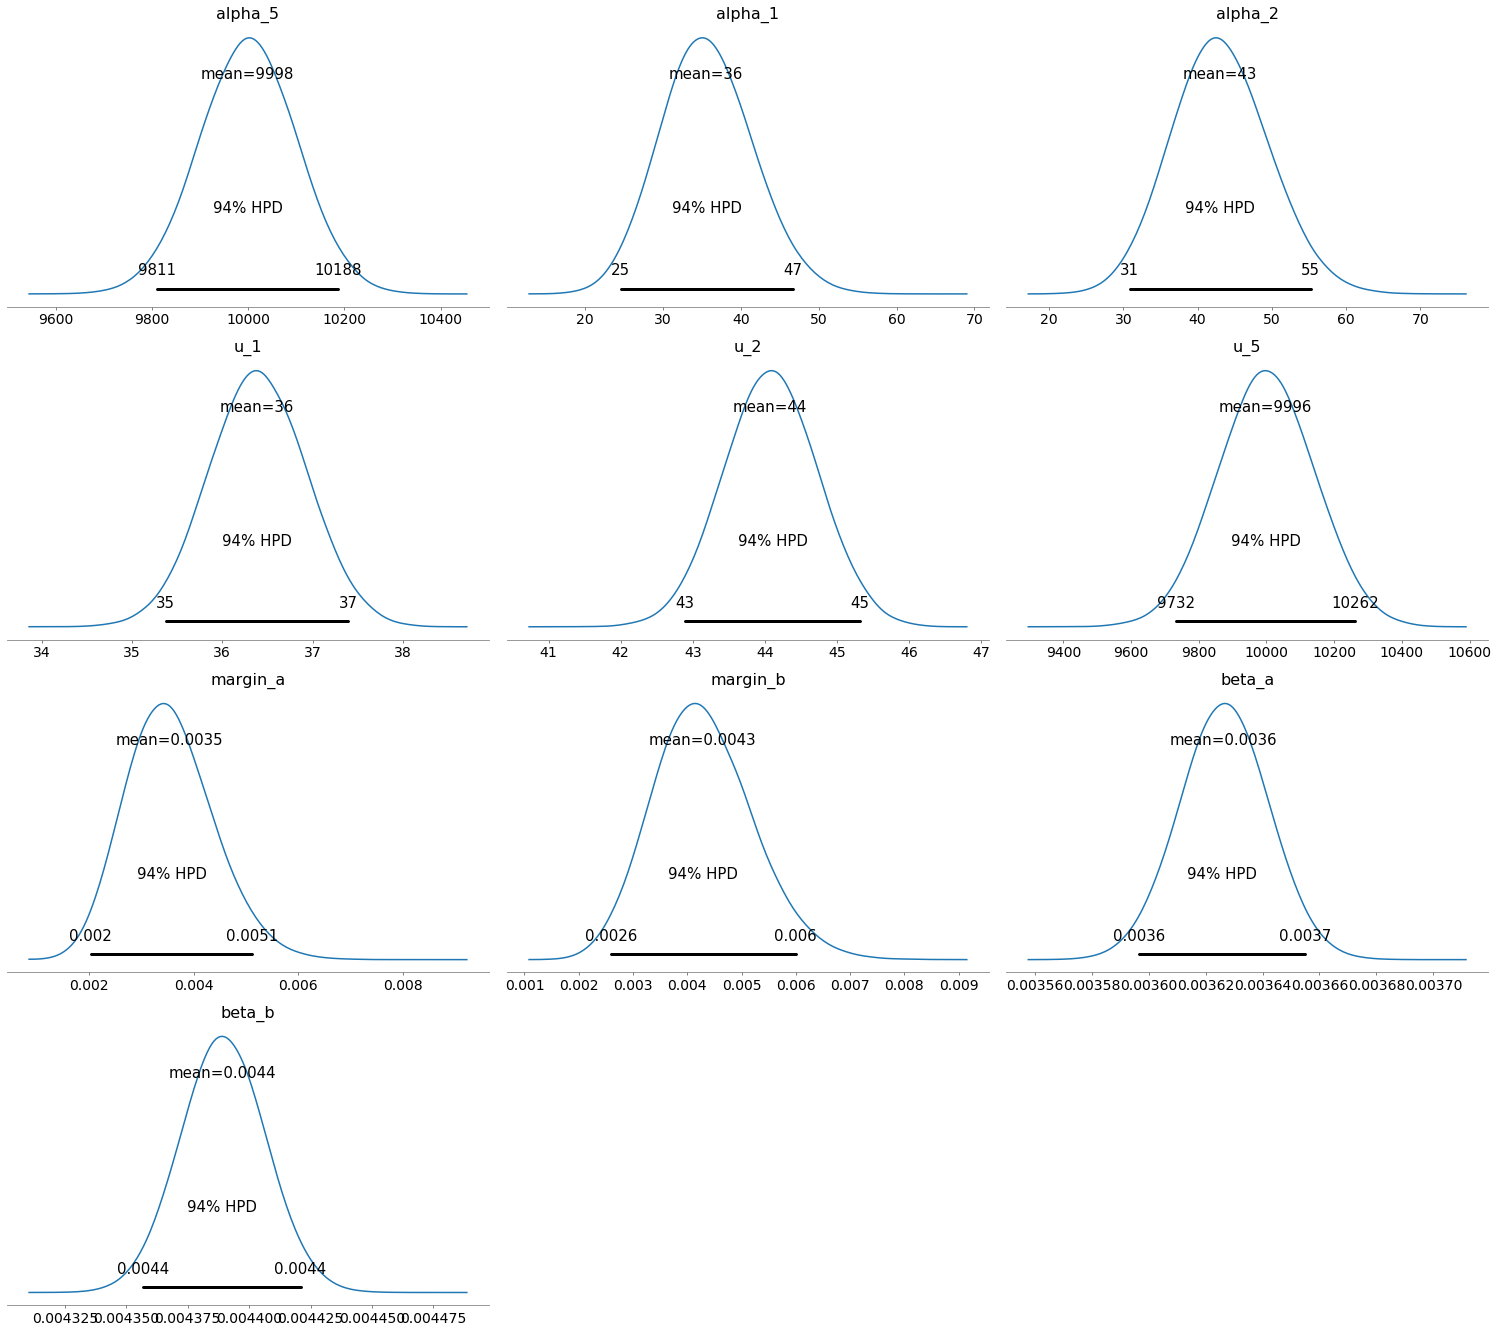

In [11]:
pm.plots.plot_posterior(trace[50000:])
plt.show()

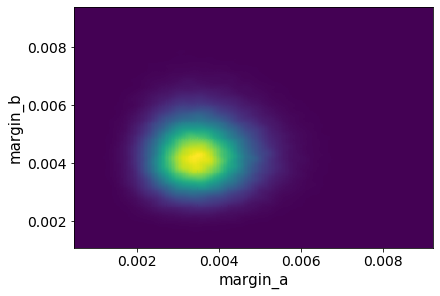

In [12]:
pm.plots.pairplot(trace, var_names=['margin_a', 'margin_b'], kind='kde', contour=False)
plt.show()

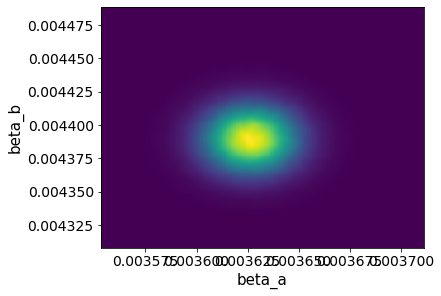

In [13]:
pm.plots.pairplot(trace, var_names=['beta_a', 'beta_b'], kind='kde', contour=False)
plt.show()

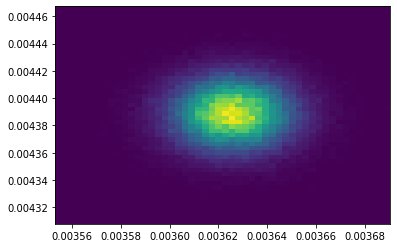

In [14]:
plt.hist2d(trace.get_values('beta_a', chains=[0], burn=10000), trace.get_values('beta_b', chains=[0], burn=10000), bins=50)
plt.show()

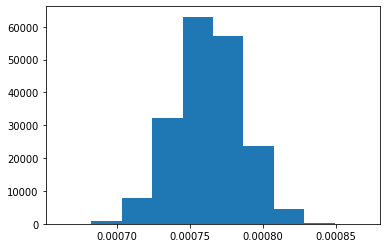

In [15]:
plt.hist(trace.get_values('beta_b', chains=[0], burn=10000) - trace.get_values('beta_a', chains=[0], burn=10000))
plt.show()

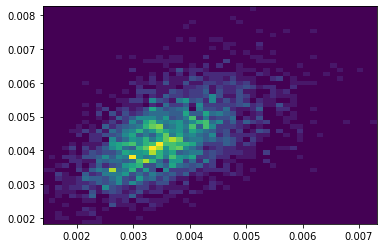

In [16]:
plt.hist2d(df['prob_a'], df['prob_b'], bins=50)
plt.show()

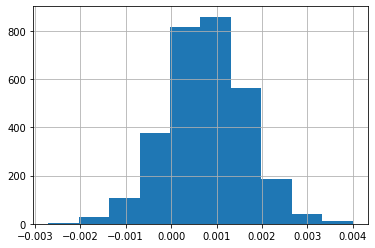

In [17]:
(df['prob_b'] - df['prob_a']).hist()
plt.show()

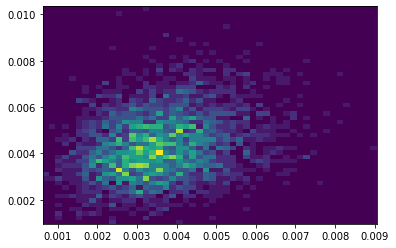

In [18]:
plt.hist2d(df['cr_a'], df['cr_b'], bins=50)
plt.show()

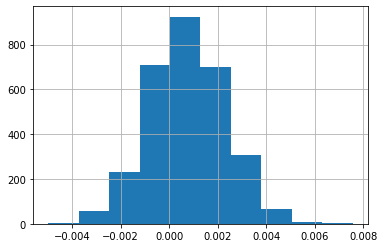

In [19]:
(df['cr_b'] - df['cr_a']).hist()
plt.show()

In [3]:
with pm.Model() as model:
    alpha_1 = pm.Exponential('alpha_1', lam=0.05)
    alpha_2 = pm.Exponential('alpha_2', lam=0.05)
#     alpha_3 = pm.Exponential('alpha_3', lam=0.05)
#     alpha_4 = pm.Exponential('alpha_4', lam=0.05)
    alpha_5 = pm.Normal('alpha_5', mu=10000, sigma=100)
    u_1 = pm.Gamma('u_1', alpha=alpha_1, beta=1)
    u_2 = pm.Gamma('u_2', alpha=alpha_2, beta=1)
#     u_3 = pm.Gamma('u_3', alpha=alpha_3, beta=1)
#     u_4 = pm.Gamma('u_4', alpha=alpha_4, beta=1)
    u_5 = pm.Gamma('u_5', alpha=alpha_5, beta=1)
    
    margin_a = pm.Beta('margin_a', alpha=alpha_1+0, beta=0+alpha_5)
    margin_b = pm.Beta('margin_b', alpha=alpha_2+0, beta=0+alpha_5)
    
    beta_a = pm.Deterministic('beta_a', (u_1+0)/(u_1+0+0+u_5))
    beta_b = pm.Deterministic('beta_b', (u_2+0)/(u_2+0+0+u_5))
    
    obs_a = pm.Binomial('obs_a', n=df['trials_a'].values, p=beta_a, observed=df['successes_a'].values)
    obs_b = pm.Binomial('obs_b', n=df['trials_b'].values, p=beta_b, observed=df['successes_b'].values)

C:\ProgramData\Anaconda3\envs\bayes_for_hackers\lib\site-packages\pymc3\distributions\continuous.py:88: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
